# INF575 - Labs 6-7. Reachability analysis of non-linear systems By Boyuan ZHANG 

## Defining the analysis for continuous systems: Taylor expansion in time with interval coefficients to handle uncertainty

I recommend the use the two following libraries:
- `IntervalArithmetic.jl` ([Github link](https://github.com/JuliaIntervals/IntervalArithmetic.jl)) - Can be installed using the command `Pkg.add("IntervalArithmetic")` from the Julia REPL.
- `ForwardDiff.jl` ([Github link](https://github.com/JuliaDiff/ForwardDiff.jl)) - Can be installed using the command `Pkg.add("ForwardDiff")` from the Julia REPL.

In [115]:
using Pkg
Pkg.add("IntervalArithmetic")
Pkg.add("ForwardDiff")
Pkg.add("Plots")

   Resolving package versions...


MethodError: MethodError: no method matching length(::VersionNumber)

Closest candidates are:
  length(!Matched::Union{Base.KeySet, Base.ValueIterator})
   @ Base abstractdict.jl:58
  length(!Matched::Union{LinearAlgebra.Adjoint{T, S}, LinearAlgebra.Transpose{T, S}} where {T, S})
   @ LinearAlgebra /usr/local/julia-1.9.3/share/julia/stdlib/v1.9/LinearAlgebra/src/adjtrans.jl:295
  length(!Matched::Union{SparseArrays.FixedSparseVector{Tv, Ti}, SparseArrays.SparseVector{Tv, Ti}} where {Tv, Ti})
   @ SparseArrays /usr/local/julia-1.9.3/share/julia/stdlib/v1.9/SparseArrays/src/sparsevector.jl:95
  ...


In [116]:
using IntervalArithmetic
using IntervalArithmetic.Symbols
using ForwardDiff
using Plots


You will probably need to define an inclusion function over vectors (of intervals) by extending the Base inclusion function issubset (which is defined also on Intervals)

In [117]:
import Base:issubset
function issubset(A::Vector, B::Vector)
    """
    Extends the Base method issubset by implementing the inclusion test of A in B for vectors of Intervals
    
    # Arguments
        A, B: vectors of Intervals with same lengths
    
    # Returns:
        true iff A is subset of B
    """
    #! didnt use ,becuse it is not recognized , use issubset_interval instead
    for i in 1:length(A)
        if !issubset(A[i], B[i])
            return false
        end
    end
    # fancy solution return all(x -> x in B, A)
    return true
end

issubset (generic function with 11 methods)

We can start by defining a function `step1` which computes an apriori enclosure $B$ for time step $[t_j,t_j+h]$.

In [118]:
function step1(f::Function, X_j::Vector, h0::Real, a::Real)
    """
    Step 1 of Taylor estimation: Computes an a priori bounding box B and a timestep h such that x([tj, tj + h]) is included in B
    
    # Arguments
    - f : the function representing the vector flow of the differential equation
    - Xj : enclosure of x at time tj (vector of Intervals)
    - h0 : initialization for time step
    - a : relaxation factor
  
    # Returns:
        B: a priori bounding box valid on [tj, tj + h] (vector of Intervals)
        h: corresponding time step
    """
    h = h0
    B = X_j + interval(0, h) * f(X_j) 
    while !issubset_interval(X_j + interval(0, h) * f(B),  B)
        B = X_j + interval(0, h) * f(B) 
        B = B + interval(-a, a) * B  
        h /= 2
        # set a minimum value for h = 0.001
        if h < 0.01 # if h is too small, we stop the process
            h = 0.1
        end
    end
    
    return B, h
    
end

step1 (generic function with 1 method)

The second step consists in evaluating the Taylor expansion time $t_j+h$ to compute a tighter enclosure of the solution $X_{j+1}$

In [119]:
function step2(X_j::Vector, B::Vector, k::Real, h::Real, Lie_f::Array)
    """
    Step 2 of Taylor polynomials in time with interval coefficients: computes new enclosure
    
    # Arguments
        X_j: enclosure at the end of previous step (vector of Intervals)
        B: a priori bounding box (vector of Intervals)
        h: width of the current step
        k: order of Taylor polynomials
        Lie: array containing at least the k first Lie derivatives of f
        
    # Returns:
        X_next: enclosure of solution at the end of the current step
    """
    
   # Initialize the result vector with same size as X_j
   X_next = similar(X_j)
    
   # Implement the formula: X_{j+1} = X_j + sum_{i=1}^{k-1} (h^i/i!)L_f^i(X_j) + (h^k/k!)L_f^k(B)
   
   # First term: X_j
   X_next = copy(X_j)
   
   # Second term: sum from i=1 to k-1 of (h^i/i!) * L_f^i(X_j)
   for i in 1:k-1
       # Calculate h^i/i!
       coeff = h^i / factorial(i)
       
       # Add the i-th Lie derivative term
       X_next += coeff * Lie_f[i](X_j)
   end
   
   # Third term: (h^k/k!) * L_f^k(B)
   coeff_k = h^k / factorial(k)
   X_next += coeff_k * Lie_f[k](B)
   # Estimate the remainder (truncation error)
   # Compute (h^(k+1) / (k+1)!) * Lie_f[k+1](B)
   # For simplicity, we can approximate the remainder as zero or include an estimation if possible

    #?remainder = h^(k+1) / factorial(k+1) * Lie_f[k+1](B)
    #?X_next += remainder
    #?BoundsError: attempt to access 4-element Vector{Function} at index [5]


   # Return the updated enclosure
   return X_next
end

step2 (generic function with 1 method)

Finally you can implement the Taylor expansion based reachability analysis

In [120]:
function TaylorReach(f::Function, k::Integer, X_0::Vector, t_f::Real, h_0::Real = 0.1)
    """
    Implements Reachability analysis by Taylor polynomials in time with interval coefficients and guaranteed error bounds, 
    to approximate the solution of non-linear uncertain initial value problems.  

    # Arguments
        f: vector-valued function of interest
        k: order of Taylor polynomials
        X_0: initial values at t=0 (vector of Intervals)
        t_f: final time of integration
        h_0: initial step (default: 0.1)
        
    Returns:
        X_j: enclosure returned by the Taylor algorithm at t=t_f
        X: enclosure obtained at each step of the algorithm
        H: width of each step
        B: a priori bounding boxes at each step
    """
    
    h = h_0
    X_j = X_0
    t = 0
    
    # Compute Lie derivatives
    Lie_f = Array{Function}(undef, k)
    Lie_f[1] = x -> f(x)
    for i in 2:k
        # To be completed
        prev_f = Lie_f[i-1]
        Lie_f[i] = x -> ForwardDiff.jacobian(prev_f, x) * f(x)
    end
    
    X = [X_0]
    H = [h]
    B = []
    
    # To be completed
    #while ...
    while t < t_f
        if t + h > t_f
            h = t_f - t
        end
    println("t = ", t, " h = ", h)
    
    # Step 1: Compute bounding box
    B_j, h = step1(f, X_j, h, 0.5) # Adjust step size if neede
    
    # Step 2: Compute tighter enclosure using Taylor expansion
    X_j = step2(X_j, B_j, k, h, Lie_f)

    # Update time and store results
    t += h
    push!(X, X_j)
    push!(H, h)
    push!(B, B_j)
        # the below to keep results at all time steps
        #push!(X, X_j)
        #push!(H, h)
        #push!(B, B_j)
    #end
    end
    return X_j, X, H, B
end

TaylorReach (generic function with 2 methods)

## Simple tests

### 1-D example from the lecture

You can start by testing the `step1` function with the small exercise from the lecture slides $\dot{x} = -x$, for instance:

In [121]:
step1(x -> [-x[1]], [1..1], 1.0, 0.5)

(Interval{Float64}[[0.0, 1.0]_com], 1.0)

You can then run the reachability analysis on the small example from the lecture $\dot{x} = -x$ and estimate $x(1)$ with $x(0) = 1$ and order 4 taylor model with minimum stepsize 0.1.

In [122]:
f1(x::Vector) = [-x[1]]
X_f1, X_1, H_1, B_1 = TaylorReach(f1, 4, [1..1], 1, 0.1)

println("Exact solution: ", exp(-1)) #x(t) = exp(-t)
println("Taylor solution: ", X_f1)
println("Subset? ", issubset_interval([exp(-1)..exp(-1)], X_f1))

t = 0 h = 0.1
t = 0.1 h = 0.1
t = 0.2 h = 0.1
t = 0.30000000000000004 h = 0.1
t = 0.4 h = 0.1
t = 0.5 h = 0.1
t = 0.6 h = 0.1
t = 0.7 h = 0.1
t = 0.7999999999999999 h = 0.1
t = 0.8999999999999999 h = 0.1
t = 0.9999999999999999 h = 1.1102230246251565e-16
Exact solution: 0.36787944117144233
Taylor solution: Interval{Float64}[[0.367876, 0.367882]_com_NG]
Subset? true


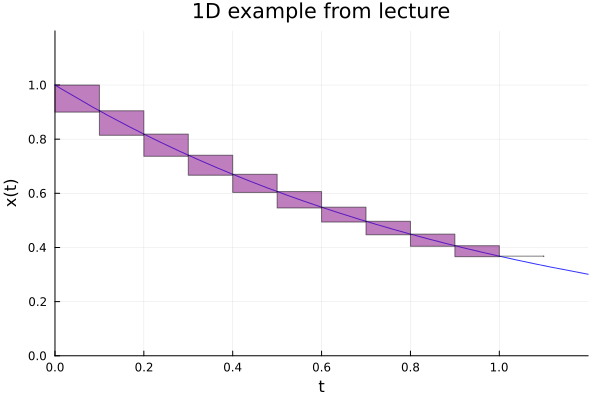

In [123]:
# Function to plot Intervals as rectangles
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

# Plot of the analytical solution, with the a priori bounding boxes and final enclosure

# Analytical solution
plot(t->exp(-t), vars=(0, 3), linecolor="blue",  color=:blue,  alpha=0.8,
    xlab="t", ylab="x(t)", title="1D example from lecture",
    xtick=[0., 0.2, .4, .6, .8, 1], ytick=[0, 0.2, 0.4, 0.6, 0.8, 1],
    xlims=(0., 1.2), ylims=(0, 1.2))

# Add on same plot the computed a priori bounding boxes and successive enclosures ?
t = 0
for i in 1:length(B_1)
    p = plot!(rectangle(H_1[i], diam(B_1[i][1]), t, mid(B_1[i][1], 0)), opacity=0.5, color=:purple, legend=false)
    t += H_1[i]
end
plot!(rectangle(0, diam(X_f1[1]), t, mid(X_f1[1], 0)), color=:red)

### A 2-D example

In [124]:
#Example in two dimensions (dx/dt = x+y; dy/dt = 2y) with x(0) in [1,2] and y(0) = 1 and final time Tf = 2.

f2(x::Vector) = [x[1]+x[2], 2x[2]]
X_f2, X_2, H_2, B_2 = TaylorReach(f2, 3, [1..2, 1..1], 2, 0.25)

println("Exact solution: ", [exp(4)..exp(4)+exp(2), exp(4)]) # x(t) = aexp(t)+exp(2t) where 0<=a<=1 (for x(0) in [1,2])
                                                             # y(t) = exp(2t)
println("Taylor solution: ", X_f2)
println("Subset? ", issubset_interval([exp(4)..exp(4)+exp(2), exp(4)], X_f2))

t = 0 h = 0.25
t = 0.125 h = 0.125
t = 0.1875 h = 0.0625
t = 0.21875 h = 0.03125
t = 0.234375 h = 0.015625
t = 0.334375 h = 0.1
t = 0.38437499999999997 h = 0.05
t = 0.409375 h = 0.025
t = 0.421875 h = 0.0125
t = 0.521875 h = 0.1
t = 0.571875 h = 0.05
t = 0.596875 h = 0.025
t = 0.609375 h = 0.0125
t = 0.709375 h = 0.1
t = 0.759375 h = 0.05
t = 0.784375 h = 0.025
t = 0.796875 h = 0.0125
t = 0.896875 h = 0.1
t = 0.946875 h = 0.05
t = 0.971875 h = 0.025
t = 0.984375 h = 0.0125
t = 1.084375 h = 0.1
t = 1.1343750000000001 h = 0.05
t = 1.159375 h = 0.025
t = 1.171875 h = 0.0125
t = 1.271875 h = 0.1
t = 1.3218750000000001 h = 0.05
t = 1.346875 h = 0.025
t = 1.359375 h = 0.0125
t = 1.459375 h = 0.1
t = 1.5093750000000001 h = 0.05
t = 1.534375 h = 0.025
t = 1.546875 h = 0.0125
t = 1.646875 h = 0.1
t = 1.6968750000000001 h = 0.05
t = 1.721875 h = 0.025
t = 1.734375 h = 0.0125
t = 1.834375 h = 0.1
t = 1.8843750000000001 h = 0.05
t = 1.909375 h = 0.025
t = 1.921875 h = 0.0125
Exact solution: Interv

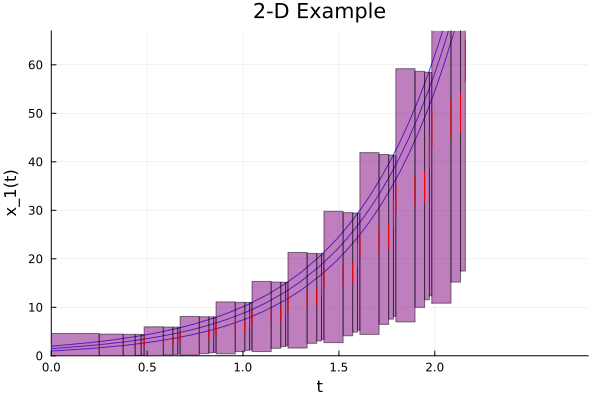

In [125]:
# Plot of the analytical solution, with the a priori bounding boxes and enclosures at each step
x = 1 #index of dimension to display
As = [0, 0.5,  1] # sampling a between 0 and 1 for printing analytical solution
plot()
# Analytical solution
for a in As
    plot!([t->a*exp(t)+exp(2t), t->exp(2t)][x], vars=(0, 3), linecolor="blue",  color=:blue,  alpha=0.8,
    xlab="t", ylab="x_1(t)", title="2-D Example",
    xtick=[0., 0.5, 1, 1.5, 2], ytick=[0, 10, 20, 30, 40, 50, 60],
    xlims=(0., 2.8), ylims=(0, 67))
end

# Computed successive enclosures
t = 0
for i in 1:length(B_2)-1
    p = plot!(rectangle(H_2[i], diam(B_2[i][x]), t, mid(B_2[i][x], 0)), opacity=0.5, color=:purple, legend=false)
    plot!(rectangle(0, diam(X_2[i+1][x]), t, mid(X_2[i+1][x], 0)), linecolor="red") 
    t += H_2[i]
end
plot!(rectangle(0, diam(X_f2[x]), t, mid(X_f2[x], 0)), linecolor="red") 

## Experiments and Comparisons on classical systems

You can use the [`ReachabilityAnalysis.jl`](https://github.com/JuliaReach/ReachabilityAnalysis.j) (installed using `Pkg.add("ReachabilityAnalysis")` from Julia REPL) library and some of [their examples](https://github.com/JuliaReach/ReachabilityAnalysis.jl/tree/master/examples) to compare with your implementation. See also lab description. 

## Improving the analysis
See suggestions in lab description

The JuliaReach library implements all the infrastructure useful for reachability analysis. In particular, you can use their Reachability Analysis for comparisons/validation of your own work. This validation includes evaluating accuracy and running time, influence of the order of Taylor models, etc.

You can take as test cases any example from the Julia Reachability examples. For instance, the quadrotor altitude control is easier to solve than it looks, the epidemic model SEIR is also classical and quite stable. On the other hand, some examples such as the Brusselator are very compact in their formulation but numerically quite difficult. You can also consider some of the hybrid models if you implement the extension to hybrid systems reachability. (see also ReachabilityModels)